In [1]:
using Pkg
Pkg.activate(".")
Pkg.add("Catalyst")
Pkg.add("JumpProcesses")
Pkg.add("Plots")

  Activating new project at `~/Desktop/catalyst_convergence`
   Resolving package versions...
    Updating `~/Desktop/catalyst_convergence/Project.toml`
  [479239e8] + Catalyst v15.0.8
    Updating `~/Desktop/catalyst_convergence/Manifest.toml`
  [47edcb42] + ADTypes v1.14.0
  [1520ce14] + AbstractTrees v0.4.5
  [7d9f7c33] + Accessors v0.1.42
  [79e6a3ab] + Adapt v4.3.0
  [66dad0bd] + AliasTables v1.1.3
  [ec485272] + ArnoldiMethod v0.4.0
  [4fba245c] + ArrayInterface v7.19.0
  [4c555306] + ArrayLayouts v1.11.1
  [e2ed5e7c] + Bijections v0.2.2
  [62783981] + BitTwiddlingConvenienceFunctions v0.1.6
  [8e7c35d0] + BlockArrays v1.6.3
  [70df07ce] + BracketingNonlinearSolve v1.3.0
  [2a0fbf3d] + CPUSummary v0.2.6
  [479239e8] + Catalyst v15.0.8
  [d360d2e6] + ChainRulesCore v1.25.1
  [fb6a15b2] + CloseOpenIntervals v0.1.13
  [861a8166] + Combinatorics v1.0.3
  [a80b9123] + CommonMark v0.9.1
  [38540f10] + CommonSolve v0.2.4
  [bbf7d656] + CommonSubexpressions v0.3.1
  [f70d9fcc] + CommonWo

In [19]:
using Catalyst, JumpProcesses, Plots, LinearAlgebra

In [11]:
rn = @reaction_network begin
    k1, A --> 0
end
A0 = 1000
u0 = [rn.A => A0]
p = [rn.k1 => 1.0]
tspan = (0.0, 10.0)
jinputs = JumpInputs(rn, u0, tspan, p)

JumpInputs storing
  JumpSystem: ##ReactionSystem#268
  Problem type: DiscreteProblem

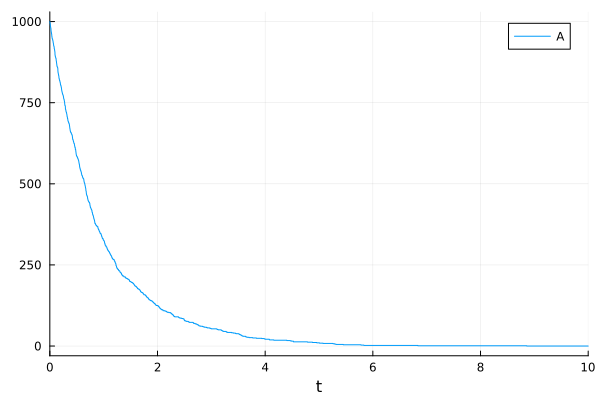

In [12]:
# test plot
jprob = JumpProblem(jinputs)
sol = solve(jprob)
plot(sol)

In [13]:
function getmean(N, jprob, times)
    Amean = zeros(length(times))
    for i in 1:N
        sol = solve(jprob; saveat = times)
        Amean .+= sol[:A]
    end
    Amean ./= N
    return Amean
end

getmean (generic function with 1 method)

In [15]:
jprob = JumpProblem(jinputs; save_positions = (false, false))
times = range(0.0, tspan[2], length = 100)
N = 1000
Amean = getmean(N, jprob, times)

100-element Vector{Float64}:
 1000.0
  903.578
  817.203
  738.333
  667.116
  602.776
  544.647
  492.028
  444.431
  401.531
    ⋮
    0.098
    0.085
    0.075
    0.067
    0.059
    0.054
    0.051
    0.046
    0.042

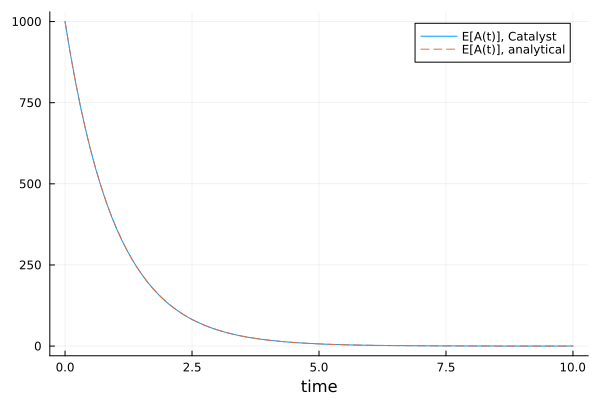

In [18]:
plt = plot(times, Amean, label = "E[A(t)], Catalyst", xlabel = "time")
plot!(plt, times, t -> A0 * exp(-last(p[1]) * t), label = "E[A(t)], analytical", linestyle = :dash)

In [27]:
# convergence plot
Nv = 2 .^ (8:2:18)
err = zeros(length(Nv))
Aact(t) = A0 * exp(-last(p[1]) * t)
for (i, N) in enumerate(Nv)
    Amean = getmean(N, jprob, times)
    err[i] = maximum(abs.(Amean .- Aact.(times)))
end
err

6-element Vector{Float64}:
 0.9321836687980749
 0.6103927686697261
 0.38285370616972614
 0.1295839093269251
 0.04957866188833293
 0.03885100061597768

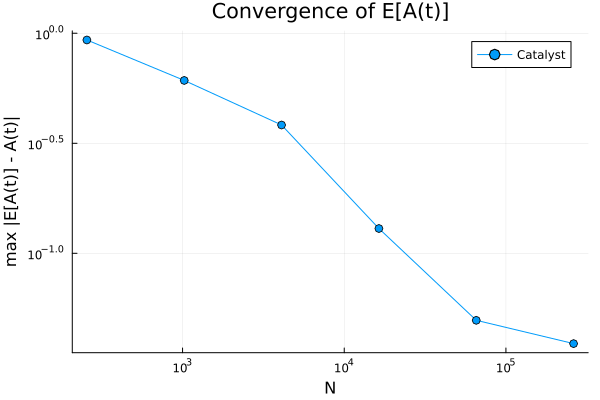

In [29]:
plot(Nv, err, xscale = :log10, yscale = :log10, marker = :o,
     xlabel = "N", ylabel = "max |E[A(t)] - A(t)|",
     title = "Convergence of E[A(t)]", label = "Catalyst")

In [32]:
# estimate the slope by least squares
x = log2.(Nv)
y = log2.(err)
A = [ones(length(x)) x]
(intercept, slope) = A \ y
slope = abs(slope)
println("Estimated slope: ", slope)

Estimated slope: 0.5050242773579217
